In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
!python -m spacy download fr_core_news_md -qq
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import fr_core_news_md
from PyPDF2 import PdfFileReader
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [41]:
# def get_documents(path):
#   """
#   Extract text from a PDF file.
#   """
#   dataset = []
#   for file in os.listdir(path):
#     if file.endswith('.pdf'):
#       pdf_file = open(path + '/' + file, 'rb')
#       pdf = PdfFleReader(pdf_file)
#       text = ""
#       for page in pdf.pages:
#           text += page.extract_text()
      
#       row = [pdf.metadata.title, text]
#     dataset.append(row)
#   df = pd.DataFrame(dataset, columns=['title', 'text'])
#   return df


# df = get_documents('../docs')
# df.head()

[Project link here](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)

### 1. Collecte des données

In [42]:
def get_documents(path):
  """
  Extract text from a PDF file.
  """
  dataset = []
  for file in os.listdir(path):
    if file.endswith('.pdf'):
      pdf_file = open(path + '/' + file, 'rb')
      pdf = PdfFileReader(pdf_file)
      text = ""
      page = pdf.getPage(-1)
      text = page.extract_text()      
      row = [str(file), text]
    dataset.append(row)
  df = pd.DataFrame(dataset, columns=['PDF', 'Content'])
  return df


df = get_documents('../docs')
df.head()

/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/PyPDF2/_reader.py:1358: PdfReadWarning: Xref table not zero-indexed. ID numbers for objects will be corrected.
  warnings.warn(
/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/PyPDF2/_page.py:1238: PdfReadWarning:  impossible to decode XFormObject /Im0
  warnings.warn(


,PDF,Content
0,BEA2016-0759.pdf,8/8\n Les enquêtes du BEA ont pour unique obj...
1,n-ca001215_05.pdf,ANNEXE R = Rupture / D = Déformation \n\n ...
2,n-tg000906_06.pdf,www.bea.aero\n\n\nn-tg000906 / Mars 2012\n\nRA...


### 2. Processer les données

In [43]:
# Notre modèle spqcy:
nlp = fr_core_news_md.load()
# Tages à supprimer du text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['Content']):
   report_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(report_tok)

df['tokens'] = tokens
df['tokens']

/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: 

0    [enquête, bea, unique, objectif, amélioration,...
1                 [annexe, r, rupture, d, déformation]
2    [n, mars, rapport, accident, commandant, bord,...
Name: tokens, dtype: object

## 3. Creation du dictionnaire et du corpus

### Creation du dictionnary

In [44]:
dictionary = Dictionary(df['tokens'])
# dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
print(dictionary.token2id)

{'accident': 0, 'acquérir': 1, 'altitude': 2, 'amélioration': 3, 'aménager': 4, 'approche': 5, 'associer': 6, 'autoroute': 7, 'avion': 8, 'axe': 9, 'aérien': 10, 'bande': 11, 'baser': 12, 'bea': 13, 'bord': 14, 'cohérence': 15, 'collision': 16, 'compte': 17, 'conclusion': 18, 'condition': 19, 'conduire': 20, 'confusion': 21, 'contrôle': 22, 'cours': 23, 'difficile': 24, 'droite': 25, 'débuter': 26, 'décision': 27, 'décrocher': 28, 'désaxé': 29, 'détermination': 30, 'déterminer': 31, 'engendrer': 32, 'enquête': 33, 'entrer': 34, 'erroné': 35, 'extérieur': 36, 'faute': 37, 'final': 38, 'fonder': 39, 'ft': 40, 'gauche': 41, 'gaz': 42, 'givrage': 43, 'guidage': 44, 'illustre': 45, 'imc': 46, 'importance': 47, 'incohérence': 48, 'information': 49, 'instrument': 50, 'interrompre': 51, 'issu': 52, 'issue': 53, 'maintenir': 54, 'manœuvre': 55, 'marginal': 56, 'montée': 57, 'météorologique': 58, 'objectif': 59, 'octobre': 60, 'perdre': 61, 'perte': 62, 'phase': 63, 'phénomène': 64, 'pilote': 65

### Création de notre corpus

In [45]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=3, workers = 4, passes=10)

## 4. Création du modèle

## Calcul du score de cohérence à l'aide de $C_{umass}$ :

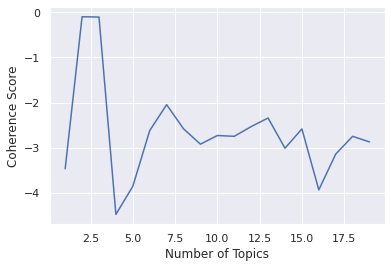

In [46]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## Calculating the coherence score using $C_v$:

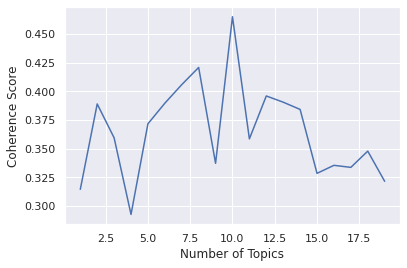

In [47]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [48]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=10, workers = 4, passes=100)

## 5. Visualisation of topics

In [49]:
lda_model.print_topics(-1)

[(0,
  '0.005*"inapproprié" + 0.005*"hélicoptère" + 0.005*"laisser" + 0.005*"indiquer" + 0.005*"indique" + 0.005*"largage" + 0.005*"inadapter" + 0.005*"hauteur" + 0.005*"hercule" + 0.005*"licence"'),
 (1,
  '0.005*"inapproprié" + 0.005*"hélicoptère" + 0.005*"laisser" + 0.005*"indiquer" + 0.005*"indique" + 0.005*"largage" + 0.005*"inadapter" + 0.005*"hauteur" + 0.005*"hercule" + 0.005*"licence"'),
 (2,
  '0.005*"inapproprié" + 0.005*"hélicoptère" + 0.005*"laisser" + 0.005*"indiquer" + 0.005*"indique" + 0.005*"largage" + 0.005*"inadapter" + 0.005*"hauteur" + 0.005*"hercule" + 0.005*"licence"'),
 (3,
  '0.005*"inapproprié" + 0.005*"hélicoptère" + 0.005*"laisser" + 0.005*"indiquer" + 0.005*"indique" + 0.005*"largage" + 0.005*"inadapter" + 0.005*"hauteur" + 0.005*"hercule" + 0.005*"licence"'),
 (4,
  '0.041*"rupture" + 0.041*"déformation" + 0.041*"annexe" + 0.041*"d" + 0.041*"r" + 0.004*"inapproprié" + 0.004*"inadapter" + 0.004*"hélicoptère" + 0.004*"indiquer" + 0.004*"heure"'),
 (5,
  '0.0

Visualisation les sujets et les mots associés à chaqeu sujet:

In [50]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/home/ibrahim/.cache/pypoetry/virtualenvs/nlp1-rattrapage-EDw6G1kG-py3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


TypeError: Object of type complex is not JSON serializable

In [51]:
pyLDAvis.save_html(lda_display, 'index.html')

TypeError: Object of type complex is not JSON serializable